Deep Convoluted GANs (DCGAN) is different from vanilla GANs in that it used Convolutional layers instead of daense layers. Idea of this experiment is to understand
1. In comparision to vanilla GANs how good DCGANs fare - Qualitative Metrics 
2. In comparision to vanilla GANs how good DCGANs fare - Quantitaive Metrics (TBD, from Inception score, MiFID, FID https://www.kaggle.com/c/generative-dog-images/overview/evaluation)
/
Data used is from Keras datasets https://keras.io/api/datasets

Importing the libraries

In [30]:
import numpy as np 
import tensorflow as tf
import os # for saving checkpoint
from tensorflow.keras import datasets # for downloading data
import matplotlib.pyplot as plt # for showing images
from tensorflow.keras import layers 
import random # for generating random number (image index)
import time # for start time of training
from IPython import display # for image display

Importing the dataset - MNIST hand written digits https://keras.io/api/datasets/mnist/. Same data set was used by original GAN), so we can later compare with dense network GAN.

In [7]:

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
# Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test) - we dont require x_test and y_test and there fore the blank
#x_train: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
#y_train: uint8 arrays of digit labels (integers in range 0-9) with shapes (num_samples,)


11493376/11490434 [==============================] - 0s 0us/step


Check the downloaded data

In [8]:
train_images.shape
# around 60000 images

(60000, 28, 28)

Label:  7


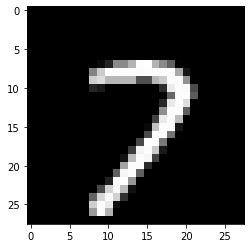

In [10]:
# visualizing the data
n = random.randint(0,train_images.shape[0]-1)# generated a random integer between 0 and image index
img = train_images[n].reshape((28, 28)) # using the index, get the image reshaped to 28, 28, [ understood by stackoverflow comments]
label = train_labels[n] # the label for the corresponding index
print("Label: ",label)
plt.imshow(img, cmap='gray')
plt.show()

Normalizing and creating memory efficient dataset 

In [11]:
# normalising the image data set
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') # creating tensor by reshaping 60K, 28, 28, 1
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1], also we use tanh as the output of the generator

In [12]:
#creating dataset using https://www.tensorflow.org/api_docs/python/tf/data/Dataset API
BATCH_SIZE = 256
BUFFER_SIZE = 600000
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

**Creating the Models**

First we would create **generator**: this takes in a noise and looks to create 28x28x1 image

In [13]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # Note: model takes input shape of 100, 7*7*256/28*28 = 16; 16 = 2^4, we would have 4-1 =3 de-convulational layers
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) # Deconvolution
    assert model.output_shape == (None, 7, 7, 128) # makes sure that the shape is now 7x7x128
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64) # makes sure that the shape is now 14x14x64
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


Checking if the generator is able to generate any image

(1, 100)


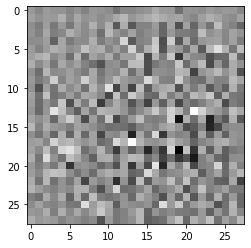

In [15]:
noise = tf.random.normal([1, 100])  # random noise  created from normal distribution
print(noise.shape)
generator = generator_model() # creating an object of the model
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

First we would create **discriminator**: this takes in a 28x28x1 image and classifies it into fake and real

In [16]:
def discriminator_model(): # the model is revese of generator, but has last layer for classification
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3)) # avoids overfitting

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3)) # avoids overfitting

    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # we need only binary classification

    return model

In [17]:
discriminator = discriminator_model()
decision = discriminator(generated_image) # decision on the generated image should be near zero when we start
print (decision)

tf.Tensor([[-0.00059564]], shape=(1, 1), dtype=float32)


**Loss Function - Cross Entropy**, as it is a binary classification
**Optimizer - Adam**, it is suggested in the paper

In [18]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# this is a different function fron binary_crossentropy, which only calculates the loss once the y_actual and y_pred is provided

**Discriminator Loss** : The below method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [19]:
# Discriminator loss function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # y_actual = 1, y_pred= output of discriminator, ideally 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # y_actual = 0, y_pred= output of discriminator, ideally 0
    total_loss = real_loss + fake_loss
    return total_loss

**Generator loss**: The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) 

In [21]:
#The discriminator and the generator optimizers are different since we will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Save Checkpoints

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

***Training Loop***

In [23]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and Save Images**

In [26]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

**Train the model**
Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

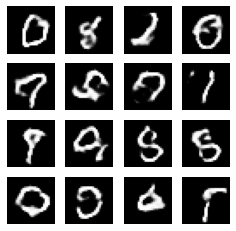

In [31]:
train(train_dataset, EPOCHS)

Restoring the latest checkpoint

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))